In [2]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Imputer
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplitModel
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, lit
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [3]:
root_dir = "/data/lab/STA323/hw04/"

spark = SparkSession.builder\
    .config("spark.executorEnv.PYSPARK_PYTHON","/root/anaconda3/bin/python") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.log.level", "ERROR") \
    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.4") \
    .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
    .appName("HW04").getOrCreate()
        # .config("spark.jars", root_dir + "./jar/synapseml_2.12-1.0.4.jar") \
    # .config("spark.synapse.lightgbm.useBarrierExecuteMode", "true") \
    # .config("spark.synapse.lightgbm.numThreads", 1) \
    #     .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.4") \
    # .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
    # 
    

https://mmlspark.azureedge.net/maven added as a remote repository with the name: repo-1
Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-5e5b5540-2ed2-42fb-bbbe-652a85d519f4;1.0
	confs: [default]


:: loading settings :: url = jar:file:/opt/module/spark-3.5.0-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found com.microsoft.azure#synapseml_2.12;1.0.4 in central
	found com.microsoft.azure#synapseml-core_2.12;1.0.4 in central
	found org.apache.spark#spark-avro_2.12;3.4.1 in central
	found org.tukaani#xz;1.9 in central
	found commons-lang#commons-lang;2.6 in central
	found org.scalactic#scalactic_2.12;3.2.14 in central
	found org.scala-lang#scala-reflect;2.12.15 in central
	found io.spray#spray-json_2.12;1.3.5 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents.client5#httpclient5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5-h2;5.1.3 in central
	found org.slf4j#slf4j-api;1.7.25 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpmime;4.5.13 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found commons-logging#commons-logging;1.2 in central

In [4]:
import synapse.ml

In [5]:
data = spark.read.csv("./data/Q1_house_price_data/train.csv", header=True, inferSchema=True)

In [6]:
test_data_origin = spark.read.csv("./data/Q1_house_price_data/test.csv", header=True, schema = data.schema)

In [7]:
data = data.fillna(0)
test_data = test_data_origin.fillna(0)

def transform(df, df_test):
    df_test = df_test.withColumn("SalePrice", lit(-1))
    df_copy = df.union(df_test)
    columns = []
    stringIndexers = []
    ohes = []
    for col in df.schema:
        if col == "Utilities":
            continue
        if isinstance(col.dataType, StringType):
            columns.append(col.name + "OHE")
            stringIndexer = StringIndexer().setInputCol(col.name).setOutputCol(col.name + "Ind").fit(df_copy)
            df_copy = stringIndexer.transform(df_copy)
            ohe = OneHotEncoder().setInputCol(col.name + "Ind").setOutputCol(col.name + "OHE").fit(df_copy)            
            df_copy = ohe.transform(df_copy)
            
            stringIndexers.append(stringIndexer)
            ohes.append(ohe)
        else:
            columns.append(col.name)

    df_test = df_copy.filter(df_copy.SalePrice == -1)
    df = df_copy.filter(df_copy.SalePrice != -1)
    
    return df, df_test, columns, stringIndexers, ohes

train_data, test_data, cols, stringIndexers, ohes = transform(data, test_data)

In [8]:
va = VectorAssembler().setInputCols(cols[1 : -1]).setOutputCol("feature")
dt = DecisionTreeRegressor(featuresCol = "feature", labelCol = cols[-1])
evaluator = RegressionEvaluator().setLabelCol("SalePrice")
grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [10, 20, 30]) \
    .addGrid(dt.minInstancesPerNode, [1, 5, 10]) \
    .build()
tvs = TrainValidationSplit(
    estimator = dt, 
    estimatorParamMaps = grid, 
    evaluator = evaluator,
    parallelism = 1, 
    trainRatio = 0.8,
    seed=42
)
va_train = va.transform(train_data)

# pipeline = Pipeline(stages = [va, dt])

In [9]:
va_test = va.transform(test_data)

In [ ]:
tvs_model = tvs.fit(va_train)

In [199]:
tvs_model.save("./output/dt.pth")

In [ ]:
predictions = tvs_model.transform(va_test)

In [9]:
predictions.select("Id", "prediction").sample(False, 0.1).show(5)

+----+------------------+
|  Id|        prediction|
+----+------------------+
|1970| 489036.8461538461|
|1977|          337900.0|
|1995|189361.68333333332|
|2008|          218236.0|
|2013|          184325.0|
+----+------------------+
only showing top 5 rows



In [9]:
import xgboost
from xgboost.spark import SparkXGBRegressor
xgb_regressor = SparkXGBRegressor(
    features_col = "feature",
    label_col = "SalePrice",
)
grid_xgb = ParamGridBuilder() \
    .addGrid(xgb_regressor.learning_rate, [0.1, 0.3, 0.5]) \
    .addGrid(xgb_regressor.max_depth, [6, 8, 10]) \
    .build()

tvs_xgb = TrainValidationSplit(
    estimator = xgb_regressor, 
    estimatorParamMaps = grid_xgb, 
    evaluator = evaluator,
    parallelism = 1, 
    trainRatio = 0.8,
    seed=42
)

In [10]:
xgb_model = tvs_xgb.fit(va_train)

2024-05-16 08:00:41,442 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[08:00:45] task 0 got new rank 0                                    (0 + 1) / 1]
2024-05-16 08:00:46,870 INFO XGBoost-PySpark: _fit Finished xgboost training!   
INFO:XGBoost-PySpark:Do the inference on the CPUs                   (1 + 1) / 2]
2024-05-16 08:00:52,715 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2024-05-16 08:00:53,150 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 8, 'objective': 'reg:squarederror', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
[08:

In [11]:
predict_xgb = xgb_model.transform(va_test)

In [12]:
predict_xgb.select("Id", "prediction").sample(False, 0.1).show(5)

INFO:XGBoost-PySpark:Do the inference on the CPUs                   (0 + 1) / 1]
2024-05-16 08:01:55,060 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
INFO:XGBoost-PySpark:Do the inference on the CPUs


+----+-------------+
|  Id|   prediction|
+----+-------------+
|1963| 98694.640625|
|1989|187828.671875|
|2054|81152.1640625|
|2055| 157643.28125|
|2059|  119607.3125|
+----+-------------+
only showing top 5 rows



In [77]:
import xgboost as xgb

In [134]:
train_df = train_data.toPandas()
test_df = test_data.toPandas()

In [130]:
for col in cols:
    if col.endswith("OHE"):
        train_df[col[:-3]] = train_df[col[:-3]].astype("category")

dtrain = xgb.DMatrix(train_df[[col.replace("OHE", "") for col in cols[1:-1]]], label = train_df["SalePrice"], enable_categorical = True)

# dtrain = xgb.DMatrix(train_df["feature"]._get_numeric_data(), label = train_df["SalePrice"], enable_categorical = True)

params = {
    'objective': 'reg:squarederror', 
    'eval_metric': 'rmse'             
}


num_rounds = 10
xgb_model = xgb.train(params, dtrain, num_rounds)

In [132]:
xgb_model.save_model("./output/xgb.json")

In [136]:
for col in cols:
    if col.endswith("OHE"):
        test_df[col[:-3]] = test_df[col[:-3]].astype("category")
dtest = xgb.DMatrix(test_df[[col.replace("OHE", "") for col in cols[1:-1]]], enable_categorical = True)
predictions = xgb_model.predict(dtest)

In [139]:
test_df["predictions"] = predictions
test_df[["Id", "predictions"]]

,Id,predictions
0,3,212435.500000
1,7,202187.984375
2,9,185455.312500
3,14,153069.390625
4,20,159011.343750
...,...,...
248,1435,162971.437500
249,1437,149057.734375
250,1452,200826.953125
251,1453,150350.265625


In [13]:
import synapse.ml

In [15]:
from synapse.ml.lightgbm import LightGBMRegressor

LC = LightGBMRegressor(
    featuresCol="feature", 
    labelCol = "SalePrice"
)
grid_lgbm = ParamGridBuilder() \
    .addGrid(LC.alpha, [0.3, 0.5]) \
    .addGrid(LC.learningRate, [0.3, 0.5]) \
    .build()

tvs_LC = TrainValidationSplit(
    estimator = LC, 
    estimatorParamMaps = grid_lgbm, 
    evaluator = evaluator,
    parallelism = 1, 
    trainRatio = 0.8,
    seed=42
)



In [16]:
LCmodel = tvs_LC.fit(va_train.select("feature", "SalePrice").filter(col("feature").isNotNull()))


[LightGBM] [Info] Saving data reference to binary buffer
[LightGBM] [Info] Loaded reference dataset: 209 features, 1207 num_data
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[LightGBM] [Info] Saving data reference to binary buffer
[LightGBM] [Info] Loaded reference dataset: 209 features, 1207 num_data
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[LightGBM] [Info] Saving data reference to binary buffer
[LightGBM] [Info] Loaded reference dataset: 209 features, 1207 num_data
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[LightGBM] [Info] Saving data reference to binary buffer
[LightGBM] [Info] Loaded reference dataset: 209 features, 1207 num_data
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[LightGBM] [Info] Saving data reference to binary buffer


[LightGBM] [Info] Loaded reference dataset: 225 features, 1460 num_data
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [17]:

pred_lgbm = LCmodel.transform(va_test)
pred_lgbm.select("Id", "prediction").sample(False, 0.1).show(5)

+----+------------------+
|  Id|        prediction|
+----+------------------+
|1961|  116094.404021644|
|1964|113483.04518325946|
|1967|301002.78605465195|
|1998| 344904.4351506987|
|2006|242136.72580701215|
+----+------------------+
only showing top 5 rows



In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA

In [212]:
user_df = spark.read.csv("./data/Q2_customer_data.csv", header = True, inferSchema = True)
user_df.show(5)
user_df.printSchema()

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows

root
 |-- InvoiceNo: string (nullable = true)
 |

In [241]:
user_df = spark.read.csv("./data/Q2_customer_data.csv", header=True, inferSchema=True)
user_df = user_df.filter(~col("InvoiceNo").startswith("c"))
user_df = user_df.select("StockCode", "Quantity", "UnitPrice", "CustomerID")
selected_columns = ["StockCodeOHE", "Quantity", "UnitPrice", "CustomerID"]

def trans(df):
    df_copy = df.select("*")
    columns = []
    stringIndexers = []
    ohes = []
    for col in df.schema:
        if isinstance(col.dataType, StringType):
            columns.append(col.name + "OHE")
            stringIndexer = StringIndexer().setInputCol(col.name).setOutputCol(col.name + "Ind").fit(df_copy)
            df_copy = stringIndexer.transform(df_copy)
            ohe = OneHotEncoder().setInputCol(col.name + "Ind").setOutputCol(col.name + "OHE").fit(df_copy)            
            df_copy = ohe.transform(df_copy)
            
            stringIndexers.append(stringIndexer)
            ohes.append(ohe)
        else:
            columns.append(col.name)
    
    return df_copy, columns, stringIndexers, ohes

user_df, user_cols, stringIndexers, ohes = trans(user_df)

In [19]:
user_df.show(5)

+---------+--------+---------+----------+------------+------------------+
|StockCode|Quantity|UnitPrice|CustomerID|StockCodeInd|      StockCodeOHE|
+---------+--------+---------+----------+------------+------------------+
|   85123A|       6|     2.55|     17850|         0.0|  (3683,[0],[1.0])|
|    71053|       6|     3.39|     17850|       403.0|(3683,[403],[1.0])|
|   84406B|       8|     2.75|     17850|       456.0|(3683,[456],[1.0])|
|   84029G|       6|     3.39|     17850|       286.0|(3683,[286],[1.0])|
|   84029E|       6|     3.39|     17850|       281.0|(3683,[281],[1.0])|
+---------+--------+---------+----------+------------+------------------+
only showing top 5 rows



In [20]:
user_df = user_df \
    .groupBy("CustomerID") \
    .agg(
        F.avg(col("Quantity")).alias("AvgQuantity"), 
        F.avg(col("UnitPrice")).alias("AvgAmount"),
        F.max("StockCodeOHE").alias("MaxStockCodeOHE")
    )

assembler = VectorAssembler(inputCols=["AvgQuantity", "AvgAmount", "MaxStockCodeOHE"], outputCol="features")
user_df = assembler.transform(user_df)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(user_df)
user_df = scaler_model.transform(user_df)

evaluator = ClusteringEvaluator()

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(featuresCol="scaledFeatures", k=k)
    model = kmeans.fit(user_df)
    predictions = model.transform(user_df)
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)



In [21]:
# Plot silhouette_scores to find the optimal k
optimal_k = np.argmax(silhouette_scores) + 2
k = optimal_k 
kmeans = KMeans(featuresCol="scaledFeatures", k = k)
model = kmeans.fit(user_df)
predictions = model.transform(user_df)

print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

predictions.select("CustomerID", "prediction").show()

Cluster Centers: 
[0.10512723 0.05508396 0.01514455 ... 0.         0.         0.01514455]
[0.00067605 0.02486922 0.         ... 0.         0.         0.        ]
[0.0077554  0.01681575 0.         ... 0.         0.         0.        ]


+----------+----------+
|CustomerID|prediction|
+----------+----------+
|     12346|         0|
|     12347|         0|
|     12348|         0|
|     12349|         0|
|     12350|         0|
|     12352|         0|
|     12353|         0|
|     12354|         0|
|     12355|         0|
|     12356|         0|
|     12357|         0|
|     12358|         0|
|     12359|         0|
|     12360|         0|
|     12361|         0|
|     12362|         0|
|     12363|         0|
|     12364|         0|
|     12365|         0|
|     12367|         0|
+----------+----------+
only showing top 20 rows



In [22]:
pca = PCA(k = k, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(predictions)
predictions = pca_model.transform(predictions)

In [23]:
pred_data = predictions.select("pcaFeatures", "prediction").rdd.map(lambda x: (x.prediction, x.pcaFeatures.toArray())).collect()
clusters, features = zip(*pred_data)
features = np.array(features)

In [24]:
tsne = TSNE(n_components = 2, random_state = 42)
tsne_results = tsne.fit_transform(features)

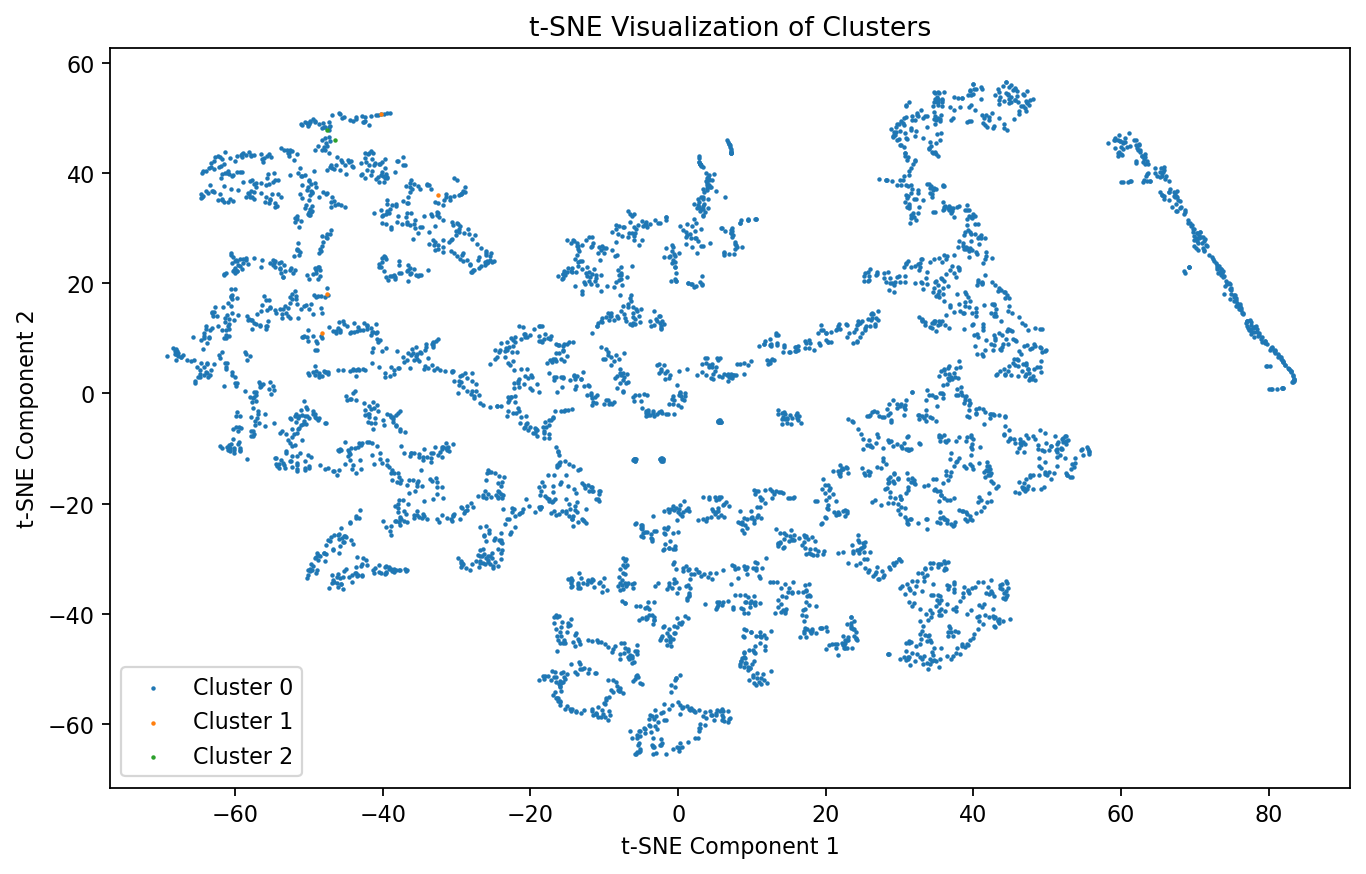

In [25]:
plt.figure(figsize=(10, 6), dpi = 160)
for cluster in range(k):
    cluster_indices = np.where(np.array(clusters) == cluster)[0]
    plt.scatter(tsne_results[cluster_indices, 0], tsne_results[cluster_indices, 1], label=f'Cluster {cluster}', s = 1)

plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()